In [1]:
include("notebook_preamble.jl");

In [2]:
using SymPy;
include("TransverseIsingModels.jl")
using .TransverseIsingModels
TIM = TransverseIsingModels;

In [3]:
⊗ₖ = kron;
const σ0 = [1 0; 0 1];
const σx = [0 1; 1 0];
const σy = [0 -im; im 0];
const σz = [1 0; 0 -1];
const σp = [0 1; 0 0];
const σm = [0 0; 1 0];

In [4]:
function siteop(A, i, n)
    i = i > 0 ? 1 + ((i - 1) % n) : throw(ArgumentError("Site index must be positive."))
    ops = repeat([one(A)], n)
    ops[i] = A
    reduce(⊗ₖ, ops)
end;

# Computation of jump operators

In [5]:
function symeigen(H)
    symeig = H.eigenvects()
    vals, vecs = eltype(H)[], []
    for (λ, _, vs) in symeig
        for v in vs
            push!(vals, λ)
            push!(vecs, vec(v))
        end
    end
    vals, vecs
end;

In [6]:
function addentry!(dict, key, value; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            push!(dict[k], value)
            return dict
        end
    end
    dict[key] = [value]
    dict
end;

In [7]:
firstvalue(i, (x, y)) = x
lastvalue(i, (x, y)) = y
function dictby(A; isequal=isequal, keyof=firstvalue, valof=lastvalue)
    i0, x0 = 1, first(A)
    k0, v0 = keyof(i0, x0), valof(i0, x0)
    dict = Dict(k0 => typeof(v0)[])
    dict = Dict()
    for (i, x) in enumerate(A)
        k, v = keyof(i, x), valof(i, x)
        addentry!(dict, k, v, isequal=isequal)
    end
    dict
end;

In [8]:
import QuantumOpticsBase: projector
projector(ψ::AbstractVector) = ψ * ψ';
TIM.sumprojector(A) = sum(projector(a) for a in A)

In [9]:
function incentry!(dict, key; isequal=isequal)
    for k in keys(dict)
        if isequal(k, key)
            dict[k] += 1
            return dict
        end
    end
    dict[key] = 1
    dict
end;

In [10]:
function combinejumps(Js)
    d = Dict()
    for J in Js
        incentry!(d, J)
    end
    [√(one(eltype(J)) * N)*J for (J, N) in d]
end;

In [11]:
function jumps(vals, vecs, As; combine=true, isequal=isequal)
    eigendict = dictby(zip(vals, vecs))
    ωs = dictby(((E2 - E1, (E1, E2)) for E1 in keys(eigendict) for E2 in keys(eigendict)), isequal=isequal)
    Πs = TIM.projectors(eigendict)
    Jωs = dictmap(ΔEs -> filter(x -> !isequal(x, zero(x)), [simplify.(sum(Πs[E1]*A*Πs[E2] for (E1, E2) in ΔEs)) for A in As]), ωs)
    combine ? dictmap(combinejumps, Jωs) : Jωs
end
spindim(v) = Int(log2(length(v)))
dipole_interactions(n) = vcat(map(A -> [siteop(A, i, n) for i in 1:n], [σx, σy, σz])...)
dipolejumps(vals, vecs; kwargs...) = jumps(vals, vecs,
    dipole_interactions(spindim(first(vecs)));
    kwargs...);

In [12]:
@vars s1p=>"σ₁⁺" s1m=>"σ₁⁻" commutative=false
@vars s2p=>"σ₂⁺" s2m=>"σ₂⁻" commutative=false
@vars s1x=>"σ₁ˣ" s2x=>"σ₂ˣ" commutative=false
@vars s1y=>"σ₁ʸ" s2y=>"σ₂ʸ" commutative=false
@vars s1z=>"σ₁ᶻ" s2z=>"σ₂ᶻ" commutative=false
@vars n1 =>"n₁"   n2=>"n₂"  commutative=false
@vars g d real=true;

In [13]:
spinops = [s1p, s1m, s2p, s2m, s1x, s2x, s1y, s2y, s1z, s2z, n1, n2];
_symspinop = cat([n1 s1p; s1m (1 - n1)], [n2 s2p; s2m (1 - n2)], dims=3)
_dummy_spinop = Dict(s => sympy.Dummy(s.name) for s in spinops);
site_collect_ops(siteops) = push!([_dummy_spinop[op] for op in siteops], 1)
_collect_ops = [a * b for a in site_collect_ops([s1p, s1m, n1]) for b in site_collect_ops([s2p, s2m, n2])];

In [14]:
u, v, w = Wild(:u), Wild(:v), Wild(:w);

In [15]:
symspinop(l, r, i) = _symspinop[l+1, r+1, i];
function jumpsimplify(J)
    s = mapreduce(+, CartesianIndices(J)[J .!= 0]) do I
        x = J[I]
        i, j = Tuple(I - CartesianIndex(1, 1))
        x * symspinop(i÷2, j÷2, 1) * symspinop(i%2, j%2, 2)
    end
    s = subs(expand(s), √(g^2 + 1) => d)
    s = s.simplify()
    s = s.xreplace(_dummy_spinop)
    for op in _collect_ops
        s = s.collect(op)
    end
    s.simplify()
end;

In [16]:
=>ₛ(a, b) = _dummy_spinop[a] => b
thesis_latex(J) = sympy.latex(J,
        imaginary_unit = "\\im",
        symbol_names = Dict(
            g   =>  "g",
            d   =>  "d",
            n1  =>ₛ "\\opr{n}_1",
            n2  =>ₛ "\\opr{n}_2",
            s1p =>ₛ "\\pauli_1^+",
            s2p =>ₛ "\\pauli_2^+",
            s1m =>ₛ "\\pauli_1^-",
            s2m =>ₛ "\\pauli_2^-",
        ));

In [17]:
function save_jump_latex(path, sJωs)
    open(path, "w") do file
        for (ω, Js) in sJωs
            sω = factor(subs(expand(ω), √(g^2 + 1) => d))
            println(file, thesis_latex(sω))
            println(file, " \\\\")
            for J in Js
                println(file, thesis_latex(J))
                println(file, " \\\\")
            end
            println(file, " \\\\")
        end
    end
end;

## Nondegenerate jump operators

In [18]:
H = -2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)

4×4 Matrix{Sym}:
 -2⋅g   0   0   -2
    0   0  -2    0
    0  -2   0    0
   -2   0   0  2⋅g

In [19]:
sJωs = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H)...; combine=true))
save_jump_latex("nondegen-jumps.tex", sJωs)

## Degenerate jump operators

In [20]:
H0 = subs.(-2*(σx ⊗ₖ σx) - g*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz), g => 0)

4×4 Matrix{Sym}:
  0   0   0  -2
  0   0  -2   0
  0  -2   0   0
 -2   0   0   0

In [21]:
sJωs0 = dictmap(Js -> jumpsimplify.(Js), dipolejumps(symeigen(H0)...; combine=true))
save_jump_latex("degen-jumps.tex", sJωs0)

# Liouvillian

## Superoperators

In [22]:
leftmul(A)  = one(A) ⊗ₖ A
rightmul(A) = permutedims(A) ⊗ₖ one(A)
comm(A, B) = A*B - B*A
acomm(A, B) = A*B + B*A
commwith(A) = leftmul(A) - rightmul(A)
acommwith(A) = leftmul(A) + rightmul(A);

In [241]:
nB(ω, β) = 1 / (exp(β*ω) - 1)
γdiv(ω; β) = isapprox(ω, 0, atol=1e-9) ? 0 : ω^3 * (nB(ω, β) + 1)
# γdiv(ω; β) = isapprox(ω, 0, atol=1e-9) ? 0 : ω^2 # High temperature approx.
ℋLSterm(J, S) = S * commwith(J' * J)
ℋLS(Jωs, S; params...) = -im * sum(ℋLSterm(J, S(ω; params...)) for (ω, Js) in Jωs for J in Js)
𝒟term(J, γ) = γ * (leftmul(J) * rightmul(J') - acommwith(J' * J) / 2)
𝒟(Jωs, γ; params...) = sum(𝒟term(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟LRterm(J, γ) = γ * (leftmul(J) * rightmul(J'))
𝒟LR(Jωs, γ; params...) = sum(𝒟LRterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);
𝒟Aterm(J, γ) = γ * (- acommwith(J' * J) / 2)
𝒟A(Jωs, γ; params...) = sum(𝒟Aterm(J, γ(ω; params...)) for (ω, Js) in Jωs for J in Js);

In [76]:
function numeigen(H)
    vals, vecs = eigen(H)
    vals, eachcol(vecs)
end

isequalto(atol=1e-9) = (x, y) -> isapprox(x, y, atol=atol)

function unitary_rates(H, dict, γ; params...)
    Jωs = dipolejumps(numeigen(N.(subs.(H, dict)))...;
        combine=true, isequal=isequalto())
    lambham = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(ℋLS(Jωs, γ; params...))
    eigvals(lambham)
end

function dissipation_rates(H, dict, γ; params...)
    Jωs = dipolejumps(numeigen(N.(subs.(H, dict)))...;
        combine=true, isequal=isequalto())
    dissipator = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(𝒟(Jωs, γ; params...))
    eigvals(dissipator)
end;

function dissipation_rates(H, γ; params...)
    Jωs = dipolejumps(numeigen(H)...; combine=true, isequal=isequalto())
    dissipator = (x -> isequalto()(x, zero(x)) ? zero(x) : x).(𝒟(Jωs, γ; params...))
    eigvals(dissipator)
end;

## Jump operators and commutation

In [391]:
Hsys = -0.5*(σx ⊗ₖ σx) - 0.5*(σz ⊗ₖ σ0 + σ0 ⊗ₖ σz)
Jωs = dipolejumps(numeigen(Hsys)...; combine=true, isequal=isequalto());

Why do the unitary (Lamb-shift or other) and dissipative superoperators commute?

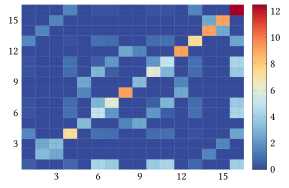

In [392]:
β = 1e1
ℒ0 = -im * commwith(Hsys)
ℒ = -im * commwith(Hsys) + 𝒟(Jωs, γdiv, β = β)
heatmap(abs.(ℒ))

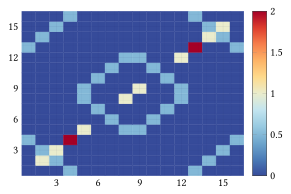

In [393]:
heatmap(abs.(ℒ0))

In [396]:
vals, vecs = eigen(ℒ)
vals0, vecs0 = eigen(ℒ0)
ρst = reshape(vecs[:, end], (4, 4))
ρst /= tr(ρst)
vals;

None of the eigenvectors correspond to positive, Hermitian operators, except for the always stable state.

In [397]:
for ρ in eachcol(vecs[:,end-3:end])
    ρ0 = reshape(ρ, (4, 4))
#     display(eigen(ρ0 / tr(ρ0)))
end

Manual solution of Liouvillian constructed from explicit dissipator superoperator.

In [398]:
P, D, Pinv = inv(vecs), vals, vecs
P0, D0, Pinv0 = inv(vecs0), vals0, vecs0
ρ0 = (σp*σm) ⊗ₖ (σp*σm) # Schrödinger picture
ξ0spin(s) = real(tr((σz ⊗ₖ σ0) * reshape(P0 * ((Pinv0 * vec(ρ0)) .* exp.(vals0 .* s)), size(ρ0))))
ξspin(s)  = real(tr((σz ⊗ₖ σ0) * reshape(P  * ((Pinv  * vec(ρ0)) .* exp.(vals  .* s)), size(ρ0))));

In [434]:
σzℒ, σzth = (
    real(tr((σz ⊗ₖ σ0) * reshape(vecs[:,end], size(ρ0)))),
    real(tr((σz ⊗ₖ σ0) * exp(-β*Hsys) / tr(exp(-β*Hsys))))
)

(0.894425275077068, 0.8925797128935687)

In [436]:
σzℒ - σzth

0.0018455621834992941

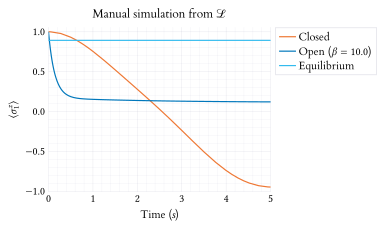

In [426]:
plot([ξ0spin ξspin (_ -> σzth)], xlim=(0.0, 5.0),
    title=L"Manual simulation from $\sopr{L}$",
    xlabel=L"Time ($s$)",
    ylabel=L"\ev{\pauli_1^z}",
    label=["Closed" L"Open ($β = \num{%$β}$)" "Equilibrium"]
)

## Dissipator eigenvalue plots

In [81]:
rubric = RGB(0.7, 0.05, 0.0);

In [82]:
function ηenergyvariance(H, η)
    Es = eigvals(H) / η
    Z = sum(exp(-E) for E in Es)
    Ps = [exp(-E) / Z for E in Es]
    H1 = sum(E * P for (E, P) in zip(Es, Ps))
    H2 = sum(E^2 * P for (E, P) in zip(Es, Ps))
    H2 - H1^2
end;

We map $E \mapsto E / \eta$ so that $\eta$ is a dimensionless inverse temperature $\beta$.

In [83]:
using Roots

In [84]:
trnorm(A) = √(tr(A'*A))
trnormalize(A) = A / trnorm(A)
∠(A, B) = acos(trnorm(trnormalize(A)' * trnormalize(B)))
function slerp(A, B, g)
    θ = ∠(A, B)
    (sin((1-g)*θ)*A + sin(g*θ)*B) / sin(θ)
end

# Requirement: `normslerp` must not change the reference Hamiltonian.
function normslerp(A, B, g)
    C = slerp(A, B, g)
    C /= trnorm(C)
end

Ainvar(g, H0) = find_zero(A -> ηenergyvariance(H0(0), 1) - ηenergyvariance(H0(g), 1/A), 1)
function Hinterp(H1, H2)
    H0(g) = normslerp(trnormalize(H1), trnormalize(H2), g)
    g -> Ainvar(g, H0) * H0(g)
end

function plot_interp_rates(H1, H2, g0s; kwargs...)
    β = 1.0
    H = Hinterp(H1, H2)
    rates_ising = [real(dissipation_rates(H(g), γdiv, β = β)) for g in g0s]
    rates_free_ising = real(dissipation_rates(H(0), γdiv, β = β));
    rates_free_trans = real(dissipation_rates(H(1), γdiv, β = β));

    plot(g0s, -hcat(rates_ising...)',
        xlabel=L"Relative angle $g$",
        ylabel="Relative dissipator eigenvalues (negated)",
        color=:black,
        alpha=0.25,
        key=false;
        kwargs...)

    scatter!(repeat([g0s[1] - 2e-2], length(rates_free_ising)), -rates_free_ising,
        marker=(:rtriangle, 2, rubric),
        markerstrokecolor=rubric
    )
    scatter!(repeat([g0s[end] + 2e-2], length(rates_free_trans)), -rates_free_trans,
        marker=(:ltriangle, 2, rubric),
        markerstrokecolor=rubric
    )
end;

In [85]:
η0s = 10 .^ range(-1, 1.5, length=128)
βs = [1e-1, 2e-1, 5e-1, 1e0, 2e0, 5e0, 1e1, 2e1, 5e1];

The Ising interaction and transverse-field Hamiltonians are

In [86]:
Hx(n) = -sum(siteop(σx, i, n) * siteop(σx, i+1, n) for i in 1:n)
Hz(n) = -sum(siteop(σz, i, n) for i in 1:n);

Convenient slerp:

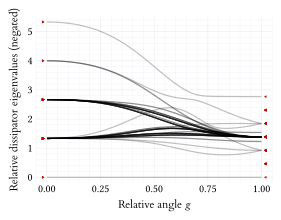

In [95]:
plot_interp_rates(Hx(3), Hz(3), range(1e-3, 1-1e-3, length=64))

In [88]:
Hp = Hinterp(Hx(6), Hz(6));

In [89]:
lgs = range(1e-3, 1-1e-3, length=64)
energies = [eigvals(Hp(g)) for g in lgs]
Hnorms = [trnorm(Hp(g))^2 for g in lgs]
energydifferences = [[x - y for (x, y) in Iterators.product(Es, Es)] for Es in energies];

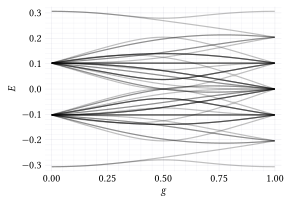

In [90]:
plot(lgs, hcat(energies...)', color=:black, alpha=0.25, key=false, xlabel=L"g", ylabel=L"E")

## Plots for seminar

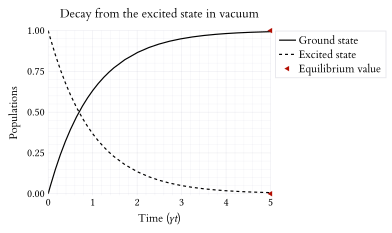

In [91]:
σ2zs(n) = -1 / (2n + 1)
σ2z(τ, n) = (1 - σ2zs(n))*exp(-τ) + σ2zs(n)
nH = 0
plot(τ -> (1 - σ2z(τ, nH))/2, label="Ground state",
    color=:black,
    xlim=(0, 5),
    ylim=(-0.01, 1),
    xlabel=L"Time ($\gamma t$)",
    ylabel="Populations",
    title="Decay from the excited state in vacuum",
)
plot!(τ -> (1 + σ2z(τ, nH))/2, xlim=(0, 5), label="Excited state", linestyle=:dash, color=:black)
scatter!(5 * [1, 1], [1 + σ2zs(nH), 1 - σ2zs(nH)] / 2, label="Equilibrium value",
    marker=(:ltriangle, 4, rubric),
    markerstrokecolor=rubric)

In [92]:
savefig("populations.pdf")